In [44]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dnnlib
import pickle
import matplotlib.pyplot as plt
from Utils.basic_utils import *
from Utils.cfg_utils import *
from Utils.cpc_utils import *
from Utils.jacobian_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device('cuda')

### First, let's  compare the effects of nonlinear CFG and linear CFG at individual time steps

In [4]:
torch.manual_seed(0)
rank = 3*64*64
# Load conditional EDM model
net_cond_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-imagenet-64x64-cond-adm.pkl'
with dnnlib.util.open_url(net_cond_pkl) as f:
    net_cond = pickle.load(f)['ema'].to(device)

# Load unconditional EDM model, this one is trained by ourselves from scratch
net_uncond_pkl = 'Imagenet_weights/network-snapshot-048000.pkl'

with dnnlib.util.open_url(net_uncond_pkl) as f:
    net_uncond = pickle.load(f)['ema'].to(device)

# Build unconditional linear model
mean_path_uncond = 'Covariance_ImageNetGenerated/uncond/mean.pt'
covariance_path_uncond = 'Covariance_ImageNetGenerated/uncond/covariance.pt' 
mean_uncond = torch.load(mean_path_uncond, weights_only=False)
mean_uncond = mean_uncond.to(device)
U, S, Vh = torch.load(covariance_path_uncond, weights_only=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
covariance_uncond = U, S, Vh
Gaussian_model_uncond = multi_gaussian(mean_uncond, covariance_uncond, low_rank=rank).to(device)

class_idx = 933 #[0, 31, 64, 207, 430, 483, 504, 817, 933, 947] # 10 randomly selected classes from ImageNet (1000 classes in total)

# Build conditional linear model
mean_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/mean.pt'
covariance_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/covariance.pt'
mean_cond = torch.load(mean_path_cond, weights_only=False)
mean_cond = mean_cond.to(device)
U, S, Vh = torch.load(covariance_path_cond, weights_only=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
covariance_cond = U, S, Vh
Gaussian_model_cond = multi_gaussian(mean_cond, covariance_cond, low_rank=rank).to(device)
    
num_show = 10
num_steps = 20
num_channels = 3
resolution = 64
latents = torch.randn(num_show, num_channels, resolution, resolution).to(device)
guidance_strength = 4
    
# Standard (naive) conditional generation with EDM
sigma_list, intermediates_EDM_cond, denoised_intermediates_EDM_cond = generate_image(net_cond, latents, num_steps=num_steps, class_idx=class_idx, device=device)

# Get EDM unconditional version of the EDM conditional sampling trajectory
denoised_intermediates_EDM_uncond = get_uncond_from_cond(net_uncond, intermediates_EDM_cond, sigma_list, num_steps=num_steps)

# Get Linear unconditional version of the EDM conditional sampling trajectory
denoised_intermediates_Gaussian_uncond = get_uncond_from_cond(Gaussian_model_uncond, intermediates_EDM_cond, sigma_list, num_steps=num_steps)

# Get Linear conditional version of the EDM unconditional sampling trajectory
denoised_intermediates_Gaussian_cond = get_uncond_from_cond(Gaussian_model_cond, intermediates_EDM_cond, sigma_list, num_steps=num_steps)

# Now, apply nonlinear and linear CFG at each individual time step
sample_list_edm = []
sample_list_linear = []
    
guidance_scale = 15
for i in range(len(sigma_list)-1):
    timestep = i
    modified_timestep = timestep + 1 # the guidance calculated at timestep i is applied to the sampling step at time step i+1
    actual_guidance_scale = guidance_scale * (sigma_list[timestep] - sigma_list[timestep+1]) / sigma_list[timestep] # here the guidance is built using the notation of 'denoised input', we scale the guidance with a time dependent constant to convert it into the context of 'score'. Score and denoised output differ by a time dependent constant scale
    guidance_direction_EDM = denoised_intermediates_EDM_cond[i] - denoised_intermediates_EDM_uncond[i]
    guidance_direction_EDM = torch.tensor(guidance_direction_EDM).to(device)
    
    guidance_direction_linear = denoised_intermediates_Gaussian_cond[i] - denoised_intermediates_Gaussian_uncond[i]
    guidance_direction_linear = guidance_direction_linear.reshape(guidance_direction_EDM.shape)
    guidance_direction_linear = torch.tensor(guidance_direction_linear).to(device)

    _, _, denoised_intermediates_modified_edm  = modify_trajectory(net_cond, num_steps, intermediates_EDM_cond, modified_timestep, modified_scale=actual_guidance_scale, modified_direction=guidance_direction_EDM, class_idx=class_idx)
    _, _, denoised_intermediates_modified_linear  = modify_trajectory(net_cond, num_steps, intermediates_EDM_cond, modified_timestep, modified_scale=actual_guidance_scale, modified_direction=guidance_direction_linear, class_idx=class_idx)
    
    sample_list_edm.append(denoised_intermediates_modified_edm[-1])
    sample_list_linear.append(denoised_intermediates_modified_linear[-1])

  0%|          | 0/20 [00:00<?, ?step/s]/scratch/qingqu_root/qingqu/forkobe/CFG Project/Utils/cfg_utils.py:2538: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_uncond = net_uncond(x_hat, torch.tensor(t_cur).to(device))
100%|██████████| 20/20 [00:00<00:00, 124.52step/s]
/tmp/ipykernel_2386267/3844983766.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guidance_direction_EDM = torch.tensor(guidance_direction_EDM).to(device)
/tmp/ipykernel_2386267/3844983766.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guidance_direction_linea

First row: step-wise EDM CFG
second row: step-wise Linear CFG


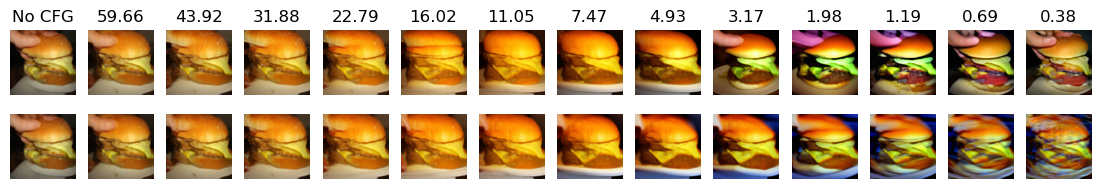

First row: step-wise EDM CFG
second row: step-wise Linear CFG


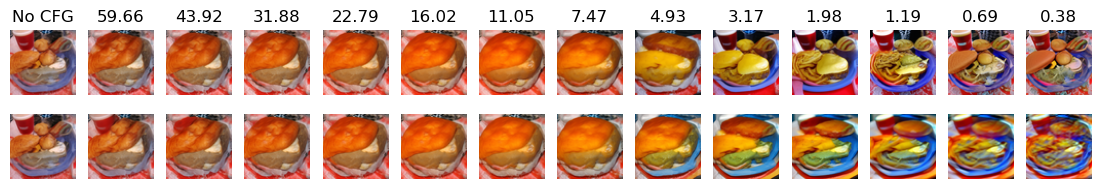

First row: step-wise EDM CFG
second row: step-wise Linear CFG


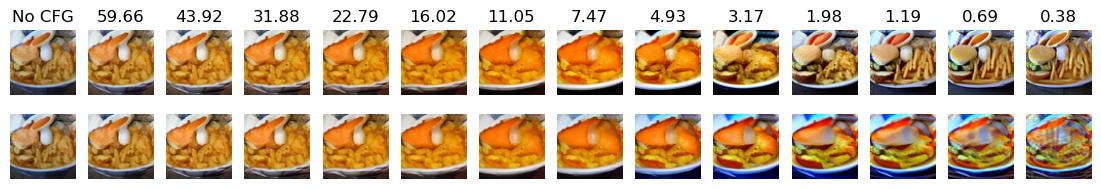

First row: step-wise EDM CFG
second row: step-wise Linear CFG


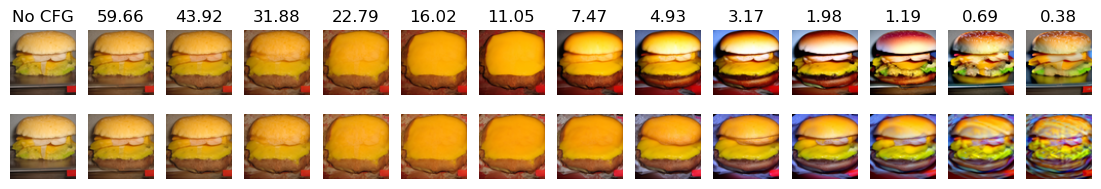

In [9]:
# Ready to visualize
sample_index_list = [0, 1, 8, 9] # selected samples
for i in sample_index_list:
    print('First row: step-wise EDM CFG')
    print('second row: step-wise Linear CFG')
    plt.figure(figsize=(20,2))
    plt.subplot(2,len(sample_list_edm)+1, 1)
    plt.imshow(normalize_image(denoised_intermediates_EDM_cond[-1][i].permute(1,2,0)))
    plt.title('No CFG')
    plt.axis('off')

    plt.subplot(2,len(sample_list_edm)+1, 1+len(sample_list_edm)+1)
    plt.imshow(normalize_image(denoised_intermediates_EDM_cond[-1][i].permute(1,2,0)))
    plt.axis('off')
    
    # Here we choose not to show the last 6 steps, as the corresponding noise level is versy low. 
    # In such cases, both conditional and unconditional denoisers can well denoise the samples with minimal differences.
    # Since CFG guidance is proportional to the difference between conditional and unconditional outputs, its effect will be minimal as well.
    for j in range(len(sample_list_edm)-6): 
        edm_cfg_sample = sample_list_edm[j][i]
        linear_cfg_sample = sample_list_linear[j][i]
        plt.subplot(2,len(sample_list_edm)+1, j+1+1)
        plt.imshow(normalize_image(edm_cfg_sample.permute(1,2,0)))
        plt.title(str(round(sigma_list[j+1],2)))
        plt.axis('off')
        plt.subplot(2,len(sample_list_edm)+1, j+1+1+len(sample_list_edm)+1)
        plt.imshow(normalize_image(linear_cfg_sample.permute(1,2,0)))
        plt.axis('off')
    plt.show()

### From the above examples, it is clear that linear CFG's effects diverge from those of the actual nonlinear CFG when noise level is relatively small. But can the previous linear analyses shed lights on the mechanisms of CFG in the nonlinear regime? In order to understand the nature of guidance in this low-noise nonlinear regime, we first visualize the conditional denoised outputs and unconditional denoised outputs along the diffusion sampling trajectories. Remember, CFG gudiance is proportional to "conditional denoised output - unconditional denoised output", hence visualizing them will be beneficial for our understanding.

First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)
second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers
third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance


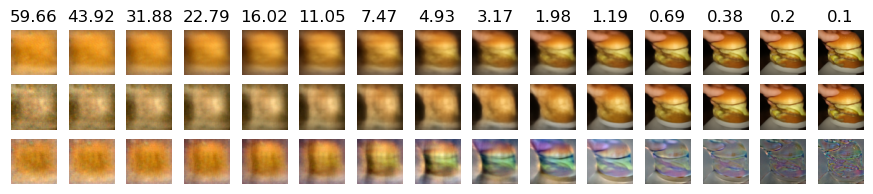

First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)
second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers
third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance


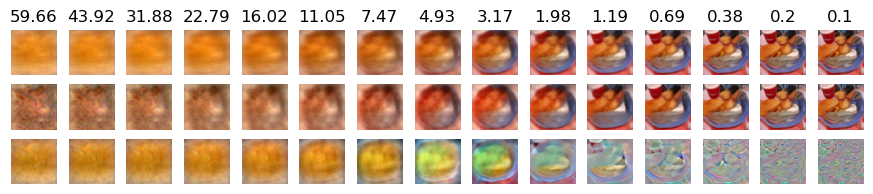

First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)
second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers
third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance


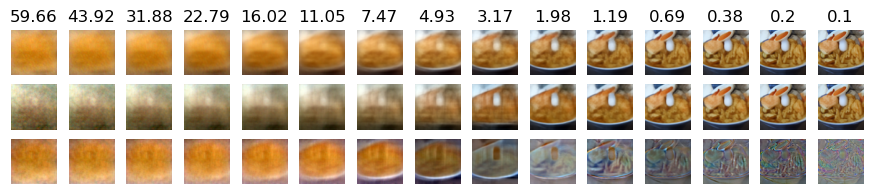

First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)
second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers
third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance


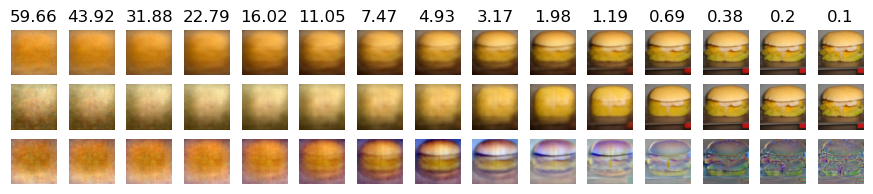

In [25]:
# Ready to visualize
sample_index_list = [0, 1, 8, 9] # selected samples
for i in sample_index_list:
    print('First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)')
    print('second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers')
    print('third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance')

    
    plt.figure(figsize=(14,2))
    # Here we choose not to show the last 6 steps, as the corresponding noise level is versy low. 
    # In such cases, both conditional and unconditional denoisers can well denoise the samples with minimal differences.
    # Since CFG guidance is proportional to the difference between conditional and unconditional outputs, its effect will be minimal as well.
    for j in range(len(sample_list_edm)-4): 
        plt.subplot(3,len(sample_list_edm), j+1)
        plt.imshow(normalize_image(denoised_intermediates_EDM_cond[j][i].permute(1,2,0)))
        plt.title(str(round(sigma_list[j+1],2)))
        plt.axis('off')
        plt.subplot(3,len(sample_list_edm), j+1+len(sample_list_edm))
        plt.imshow(normalize_image(denoised_intermediates_EDM_uncond[j][i].permute(1,2,0)))
        plt.axis('off')
        plt.subplot(3,len(sample_list_edm), j+1+2*len(sample_list_edm))
        plt.imshow(normalize_image((denoised_intermediates_EDM_cond[j][i]-denoised_intermediates_EDM_uncond[j][i]).permute(1,2,0)))
        plt.axis('off')
    plt.show()

### Note that when noise level is small, the conditional denoised outputs and the unconditional denoised outputs really do not differ that much, they differ only in some finer image features:

First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)
second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers
third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance


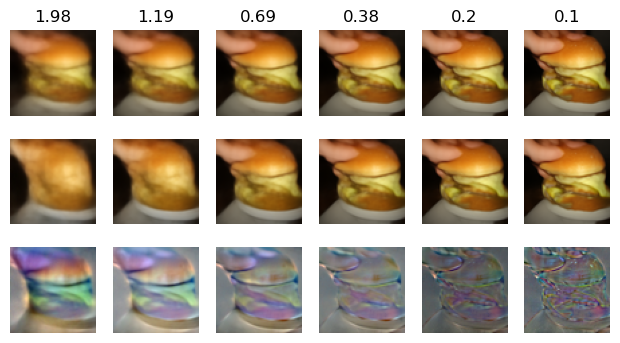

First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)
second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers
third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance


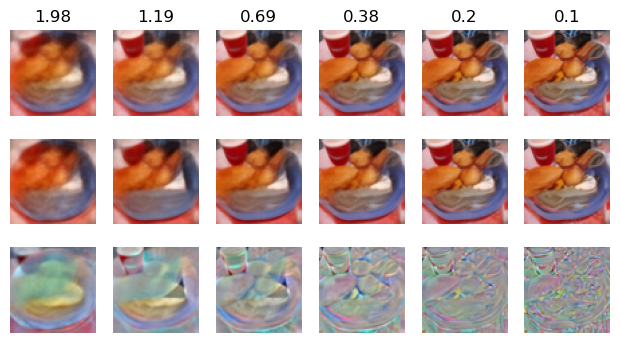

First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)
second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers
third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance


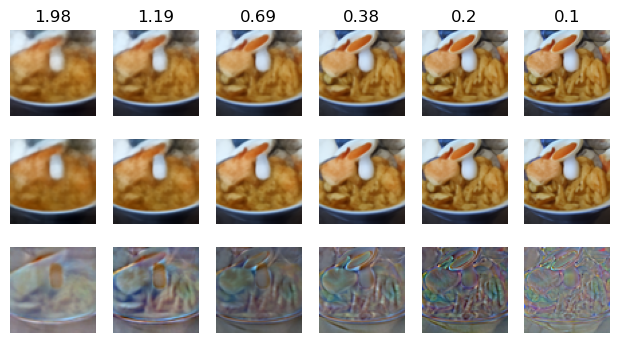

First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)
second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers
third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance


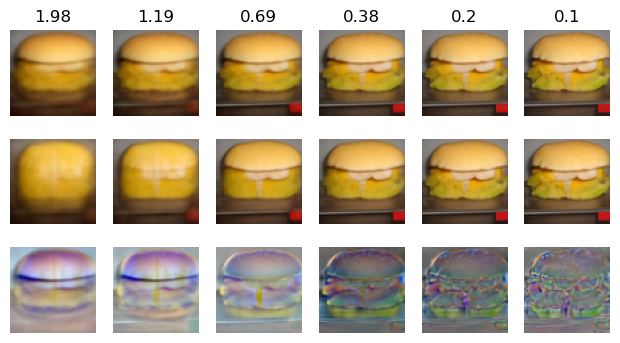

In [30]:
# Ready to visualize
sample_index_list = [0, 1, 8, 9] # selected samples
for i in sample_index_list:
    print('First row: conditional denoised outputs along a sampling trajecotry (standard sampling, no CFG)')
    print('second row: the corresponding unconditional denoised outputs, i.e., denoised x_t with unconditional denoisers')
    print('third row: conditional denoised output - unconditional denoised output, which is proportional to CFG the guidance')

    
    plt.figure(figsize=(25,4))
    # Here we choose not to show the last 6 steps, as the corresponding noise level is versy low. 
    # In such cases, both conditional and unconditional denoisers can well denoise the samples with minimal differences.
    # Since CFG guidance is proportional to the difference between conditional and unconditional outputs, its effect will be minimal as well.
    for j in range(9, len(sample_list_edm)-4): 
        plt.subplot(3,len(sample_list_edm), j+1)
        plt.imshow(normalize_image(denoised_intermediates_EDM_cond[j][i].permute(1,2,0)))
        plt.title(str(round(sigma_list[j+1],2)))
        plt.axis('off')
        plt.subplot(3,len(sample_list_edm), j+1+len(sample_list_edm))
        plt.imshow(normalize_image(denoised_intermediates_EDM_uncond[j][i].permute(1,2,0)))
        plt.axis('off')
        plt.subplot(3,len(sample_list_edm), j+1+2*len(sample_list_edm))
        plt.imshow(normalize_image((denoised_intermediates_EDM_cond[j][i]-denoised_intermediates_EDM_uncond[j][i]).permute(1,2,0)))
        plt.axis('off')
    plt.show()

### Remember in linear diffusion models, denoising is performed by a weighted projection onto the (posterior) data covariance. In linear model case, the posterior covariances can be computed in closed form. Although such closed form no longer exists for nonlinear diffusion models, we can still compute the posterior covariance by automatic differentiation. Next, we will (i) perform this computation and (ii) demonstrate that the resulting posterior covariances can be used for denoising.

In [90]:
# the noise standard deviation (noise level) of the 20 reverse sampling steps
sigma_list

[80.0,
 59.65752595034505,
 43.920260215105095,
 31.884428614579015,
 22.794110612306778,
 16.022301629862064,
 11.053666800144464,
 7.468906976395598,
 4.930657814164687,
 3.170842743448457,
 1.979400648230401,
 1.1943090706445185,
 0.6928237569884889,
 0.3838553628113907,
 0.20140413430098314,
 0.0989733831956025,
 0.044882572445709604,
 0.018400829850142464,
 0.006621706892114194,
 0.002000000000000003]

In [49]:
num_channels = 3
resolution = 64
img_idx = 0
batch_size = 1
sample_index_list = [8]#[0, 1, 8, 9] # selected samples
intermediates_EDM_cond_selected = [intermediates_EDM_cond[i][sample_index_list] for i in range(len(intermediates_EDM_cond))]


if net_cond.label_dim:
    class_labels = torch.eye(net_cond.label_dim, device=device)[torch.randint(net_cond.label_dim, size=[batch_size], device=device)]
if class_idx is not None:
    class_labels[:, :] = 0
    class_labels[:, class_idx] = 1
    
jacobians_cond_list = []
jacobians_uncond_list = []

# We compute the Jacobians for relateively low noise levels, the computation is quite expensive and can take a long time.
# In this notebook example, we only demonstrate using one example, the results in the paper are conducted with a separate python script, in which we pre-compute and store all the jacobian. 
# The scripts will be provided upon request, but we beleive this example is sufficient for demonstration purposes.
compute_steps = [12]#[9, 10, 11, 12]

for i in range(len(sigma_list)):
    if i not in compute_steps:
        continue
    print(i) # print here to check progress
    timestep = torch.tensor(sigma_list[i]).to(device)
    func_cond = lambda input: net_cond(input, timestep, class_labels)
    func_uncond = lambda input: net_uncond(input, timestep, None)
    jacobians_uncond = compute_jacobian_batch(func_uncond, intermediates_EDM_cond_selected[i].to(device)).reshape(-1, num_channels*resolution*resolution, num_channels*resolution*resolution)
    jacobians_cond = compute_jacobian_batch(func_cond, intermediates_EDM_cond_selected[i].to(device)).reshape(-1, num_channels*resolution*resolution, num_channels*resolution*resolution)
    jacobians_cond_list.append(jacobians_cond)
    jacobians_uncond_list.append(jacobians_uncond)

12


Noise level: 0.6928


(-0.5, 63.5, 63.5, -0.5)

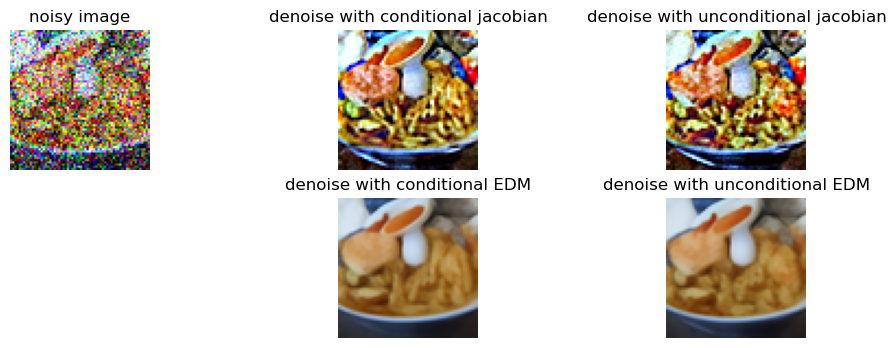

In [71]:
# now, let's denoise the intermediate sample x_t with conditional and unconditional Jacobians respectively
jacobian_cond = jacobians_cond_list[0]
jacobian_uncond = jacobians_uncond_list[0]
noisy_image = intermediates_EDM_cond[12][8] #here we hard code the index: select the 8^th sample at timestep 12
denoised_cond_jacobian = jacobian_cond@(noisy_image.reshape(-1,1).to(device))
denoised_uncond_jacobian = jacobian_uncond@(noisy_image.reshape(-1,1).to(device))

denoised_cond_edm = denoised_intermediates_EDM_cond[12][8].to(device)
denoised_uncond_edm = denoised_intermediates_EDM_uncond[12][8].to(device)


plt.figure(figsize=(12,4))
print('Noise level: '+str(round(sigma_list[12],4)))
plt.subplot(2,3,1)
plt.title('noisy image')
plt.imshow(normalize_image(noisy_image.permute(1,2,0), clip=True))
plt.axis('off')
plt.subplot(2,3,2)
plt.title('denoise with conditional jacobian')
plt.imshow(normalize_image(denoised_cond_jacobian.reshape(3,64,64).permute(1,2,0).detach().cpu(), clip=True))
plt.axis('off')
plt.subplot(2,3,3)
plt.title('denoise with unconditional jacobian')
plt.imshow(normalize_image(denoised_uncond_jacobian.reshape(3,64,64).permute(1,2,0).detach().cpu(), clip=True))
plt.axis('off')

plt.subplot(2,3,5)
plt.title('denoise with conditional EDM')
plt.imshow(normalize_image(denoised_cond_edm.permute(1,2,0).detach().cpu(), clip=True))
plt.axis('off')

plt.subplot(2,3,6)
plt.title('denoise with unconditional EDM')
plt.imshow(normalize_image(denoised_uncond_edm.permute(1,2,0).detach().cpu(), clip=True))
plt.axis('off')

### The above example shows that the jacobians can effectively denoise the noisy image, hence we can use this jacobian denoiser as a proxy for studying the actual nonlinear diffusion model. Importantly, note that both conditional and unconditional jacobians can effectively denoise the noisy image, but the former better capture certain class-specific features. For example, compared to the unconditional jacobian, the conditional jacobian better generate the texture of the fires. Similar pattern holds on the actual EDM models. Since jacobian denoiser works by projecting the input image onto the subspace spanned by the posterior covariances, the similarity between conditional and unconditional denoised outputs implies that both conditional posterior covariance and unconditional one capture the overall generic features. For guidance purpose, we want to extract the finer details captured by the conditonal jacobian. To do so, we again can use the positive CPCs, which we will demonstrate below.

In [81]:
# Construct positive cpc
jacobian_cpc = jacobian_cond[0] - jacobian_uncond[0]
S_cpc, U_cpc = torch.linalg.eigh(jacobian_cpc)

S_cpc_pos = torch.tensor(S_cpc).to(device)
S_cpc_pos[S_cpc_pos<0] = 0
jacobian_cpc_pos = U_cpc@torch.diag(S_cpc_pos)@U_cpc.T

guidance_strength = 15
timestep = 12
modified_timestep = timestep + 1 # the guidance calculated at timestep i is applied to the sampling step at time step i+1
actual_guidance_scale = guidance_scale * (sigma_list[timestep] - sigma_list[timestep+1]) / sigma_list[timestep] # here the guidance is built using the notation of 'denoised input', we scale the guidance with a time dependent constant to convert it into the context of 'score'. Score and denoised output differ by a time dependent constant scale

# construct heuristic cpc guidance in eq.(17) of the paper
positive_cpc_guidance = jacobian_cpc_pos@denoised_cond_edm.reshape(-1,1)
positive_cpc_guidance = positive_cpc_guidance.reshape(-1,3,64,64)
_, _, denoised_intermediates_modified_positive_cpc = modify_trajectory(net_cond, num_steps, intermediates_EDM_cond_selected, modified_timestep, modified_scale=actual_guidance_scale, modified_direction=positive_cpc_guidance, class_idx=class_idx)


# construct heuristic guidance that enhances all the conditional posterior PCs with no selectivity (eq.(18))
conditional_pc_guidance = jacobian_cond[0]@denoised_cond_edm.reshape(-1,1)
conditional_pc_guidance = conditional_pc_guidance.reshape(-1,3,64,64)
_, _, denoised_intermediates_modified_conditional_pc = modify_trajectory(net_cond, num_steps, intermediates_EDM_cond_selected, modified_timestep, modified_scale=actual_guidance_scale, modified_direction=conditional_pc_guidance, class_idx=class_idx)

/tmp/ipykernel_2386267/3514527868.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S_cpc_pos = torch.tensor(S_cpc).to(device)
100%|██████████| 20/20 [00:00<00:00, 94.30step/s] 


apply guidance at noise level: 0.3839


(-0.5, 63.5, 63.5, -0.5)

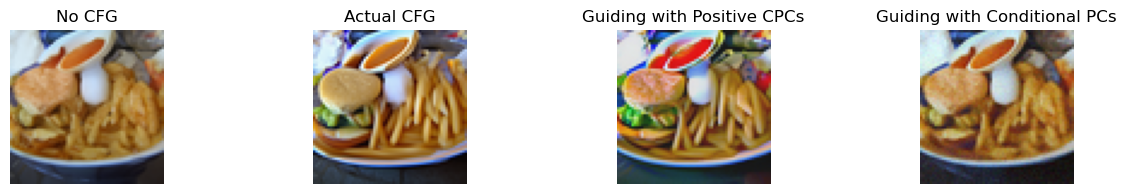

In [88]:
# Visualize
print('apply guidance at noise level: '+str(round(sigma_list[12+1],4)))
plt.figure(figsize=(15,2))
plt.subplot(141)
plt.title('No CFG')
plt.imshow(normalize_image(denoised_intermediates_EDM_cond[-1][8].permute(1,2,0)))
plt.axis('off')
plt.subplot(142)
plt.title('Actual CFG')
plt.imshow(normalize_image(sample_list_edm[12][8].permute(1,2,0)))
plt.axis('off')
plt.subplot(143)
plt.title('Guiding with Positive CPCs')
plt.imshow(normalize_image(denoised_intermediates_modified_positive_cpc[-1][0].permute(1,2,0)))
plt.axis('off')
plt.subplot(144)
plt.title('Guiding with Conditional PCs')
plt.imshow(normalize_image(denoised_intermediates_modified_conditional_pc[-1][0].permute(1,2,0)))
plt.axis('off')


### Note that guiding with positive CPCs enhances the finer details of the final sample, leading to similar effects as the actual CFG. On the other hand, guiding with all the conditional PCs with no selectivity does not lead to ideal guiding effects, which highlights the importance of identifying directions that encode class-dependent information from those represent generic structures. We note that the jacobian denoiser model is only a proxy, its effects can differ from the actual CFG in some other samples. The exact mechanism remains not fully understand due to the black-box nature of the deep network. That being said, linear analyses based on Jacobian matrices are exact for bias-free diffusion models, where key properties such as strong generalization remain consistent with those observed in real-world diffusion models ([https://openreview.net/forum?id=ANvmVS2Yr0)](https://openreview.net/forum?id=ANvmVS2Yr0)).
